In [3]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout, Reshape
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

In [4]:
data = Dataset('15min')
data = data.preprocess()
data.drop(columns=['Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
# print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 1  # Number of 15-min we want to look into the future based on the past (Out).
n_past = 16  # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(X, Y, steps, out):
    Xs, Ys = list(), list()
    for i in range(len(X)):
        end = i + steps
        outi = end + out
        if outi > len(X)-1:
            break
        seqx, seqy = X[i:end], Y[end:outi]
        Xs.append(seqx)
        Ys.append(seqy)
    return np.array(Xs), np.array(Ys)


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
data = pd.concat([data, categorical_data], axis = 1)

X = data.drop(columns='Energy')
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

X_train , Y_train =  split_sequence(X_train, Y_train, n_past, n_future)
X_val , Y_val =  split_sequence(X_val, Y_val, n_past, n_future)
X_test , Y_test =  split_sequence(X_test, Y_test, n_past, n_future)

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/CNN-LSTM/../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/CNN-LSTM/../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/CNN-LSTM/../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/CNN-LSTM/../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map 

198.23530425829813
380.9409999996424
5.430999994277954
Train sizes:
(7425, 332) (7425, 1)
Validation sizes:
(655, 332) (655, 1)
Test sizes:
(656, 332) (656, 1)


# Optuna Objective

In [3]:
# def objective(trial):
#     clear_session()
#     low = trial.suggest_categorical("low", [128, 256, 512])
#     lr_schedule = ExponentialDecay(0.0001, decay_steps=1400, decay_rate=0.96, staircase=True)
#     #how deep the layers should be
#     n_layers = trial.suggest_int("n_layers", 1, 3, step = 1)
#     model = Sequential()
    
#     for i in range(n_layers):
#         lstm_units = low * (2 ** i)
#         activation_func = trial.suggest_categorical(f"activation_func", ['relu', 'tanh', 'leaky_relu'])
#         print(lstm_units)
#         model.add(Bidirectional(LSTM(units = lstm_units, 
#                                      activation= activation_func, 
#                                      return_sequences=True, 
#                                      dropout = trial.suggest_float(f"dropout_rate_lstm_{i}", 0.1, 0.5, step = 0.1),
#                                      recurrent_dropout= trial.suggest_float(f"rec_dropout_rate_lstm_{i}", 0.1, 0.5, step = 0.1),
#                                      input_shape=(X_train.shape[1], X_train.shape[2]))))
#     model.add(TimeDistributed(Dense(units = trial.suggest_categorical("dense_units", [16, 32, 64]), activation= activation_func)))
#     model.add(Dropout(trial.suggest_float("dropout_rate", 0.1, 0.5, step = 0.1)))
#     model.add(TimeDistributed(Dense(1)))
#     model.add(Flatten())
#     model.add(Dense(n_future))
#     model.compile(loss = 'mse', optimizer = Adam(learning_rate=0.0001), metrics=['mse', 'mae', 'mape'])
    
#     history = model.fit(X_train, Y_train, epochs= 15, batch_size = trial.suggest_categorical("batch_size", [16, 32, 64, 128, 256]), validation_data=(X_val, Y_val), callbacks=[EarlyStopping(monitor='val_loss', patience=8)],
#                         verbose=1, shuffle=True)
    

#     # score
#     score = model.evaluate(X_val,Y_val)

#     return score[0]

# Optuna study run

In [4]:
# study = optuna.create_study(direction= "minimize", storage= "sqlite:///halcor_study.db", study_name="halcor_study")
# study.optimize(objective, n_trials=25, timeout=6000000000)
# print("Number of finished trials: {}".format(len(study.trials)))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: {}".format(trial.value))
# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [5]:
# import optuna.visualization as vis

# vis.plot_optimization_history(study)
# vis.plot_param_importances(study)
# vis.plot_slice(study)

# Optuna load study

In [5]:
loaded_study = optuna.load_study(study_name='halcor_study', storage="sqlite:///halcor_study.db")

best_trial = loaded_study.best_trial
best_params = best_trial.params
best_params, best_trial.value
# I can continue optimizing if it crashed or something
# loaded_study.optimize(objective, n_trials=50)

KeyError: 'Record does not exist.'

# Model (I run here the optimal hyperparams for more epochs)

In [6]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.0001, decay_steps=2500, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    # model.add(Flatten())
    # model.add(RepeatVector(n_future))
    model.add(LSTM(128, activation='relu'))
    model.add(Dropout(0.2))
    
    # Dense layer for final output
    model.add(Dense(1))
    # model.add(LSTM(256, activation='relu', return_sequences=True))
    # model.add(TimeDistributed(Dense(64, activation='relu')))
    # model.add(Dropout(0.1))
    # model.add(TimeDistributed(Dense(1)))
    # model.add(Flatten())
    # model.add(Dense(n_future))
    # model.add(Dense(n_future*len(Y_train)))
    # model.add(Reshape((n_future,len(Y_train))))
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mape'])

    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-15-min(15min).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)
model = create_model()
history = model.fit(X_train, Y_train[:, :, 0], validation_data=(X_val, Y_val[:, :, 0]), epochs=50, batch_size=16, callbacks=[checkpoint_callback, LearningRateLogger()], verbose=1, shuffle=False)

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1729361433.293645   60659 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729361433.325690   60659 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729361

Epoch 1/50


I0000 00:00:1729361434.631839   61411 service.cc:146] XLA service 0x7e13640c8e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729361434.631867   61411 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-10-19 21:10:34.654199: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-19 21:10:34.766397: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-10-19 21:10:34.858992: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

 97/463 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.1330 - mae: 0.2976 - mape: 229.4290

I0000 00:00:1729361436.058991   61411 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


453/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1077 - mae: 0.2767 - mape: 32808.9023
Epoch 1: val_loss improved from inf to 0.05552, saving model to ./models/model-15-min(15min).keras

Epoch 1: Learning rate is 0.0010000000474974513
463/463 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1072 - mae: 0.2761 - mape: 33148.7109 - val_loss: 0.0555 - val_mae: 0.1872 - val_mape: 121.8445
Epoch 2/50
441/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0658 - mae: 0.2125 - mape: 41230.4922
Epoch 2: val_loss improved from 0.05552 to 0.04518, saving model to ./models/model-15-min(15min).keras

Epoch 2: Learning rate is 0.0010000000474974513
463/463 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0658 - mae: 0.2125 - mape: 42203.6172 - val_loss: 0.0452 - val_mae: 0.1627 - val_mape: 64.1244
Epoch 3/50
445/463 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0534 - mae: 0.1853 - mape: 28740.5352
Epoch 3: val_loss improved from 0.04518 to 0.04238, saving model to ./models/model-15-min(15min).keras

Epoch 3: Learn

KeyboardInterrupt: 

In [8]:
# save model
model.save('./models/model-15-min(15min).keras')

In [44]:
from keras.models import load_model
# load model

model = load_model('./models/model-15-min(15min).keras')

# continue training for a few epochs with a lower lr

In [10]:
# model.compile(loss='mse', optimizer=Adam(learning_rate=0.00003), metrics=['mse', 'mae', 'mape'])
# model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=5, batch_size=best_params['batch_size'], verbose=1, shuffle=False)

In [7]:
predictions = model.predict(X_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [8]:
predictions.shape

(639, 1)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], 37))
for i in range(zeros.shape[0]):
    zeros[i][0] = predictions[i]


predictions = scaler_Y.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((X_test.shape[0],37))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[i]
original = scaler_Y.inverse_transform(zeros)
original = [i[0] for i in original]

# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 65.01532123807364
Mean Squared Error (MSE): 7508.0709780851275
Root Mean Squared Error (RMSE): 86.64912566255431
R² Score: 0.47665698944778023
Adjusted R² Score: 0.4631947898194273
Median Absolute Error: 45.912849988536436
Mean Absolute Percentage Error (MAPE): 104.95643225511321 %


/tmp/ipykernel_60659/1192657361.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = predictions[i]
/tmp/ipykernel_60659/1192657361.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


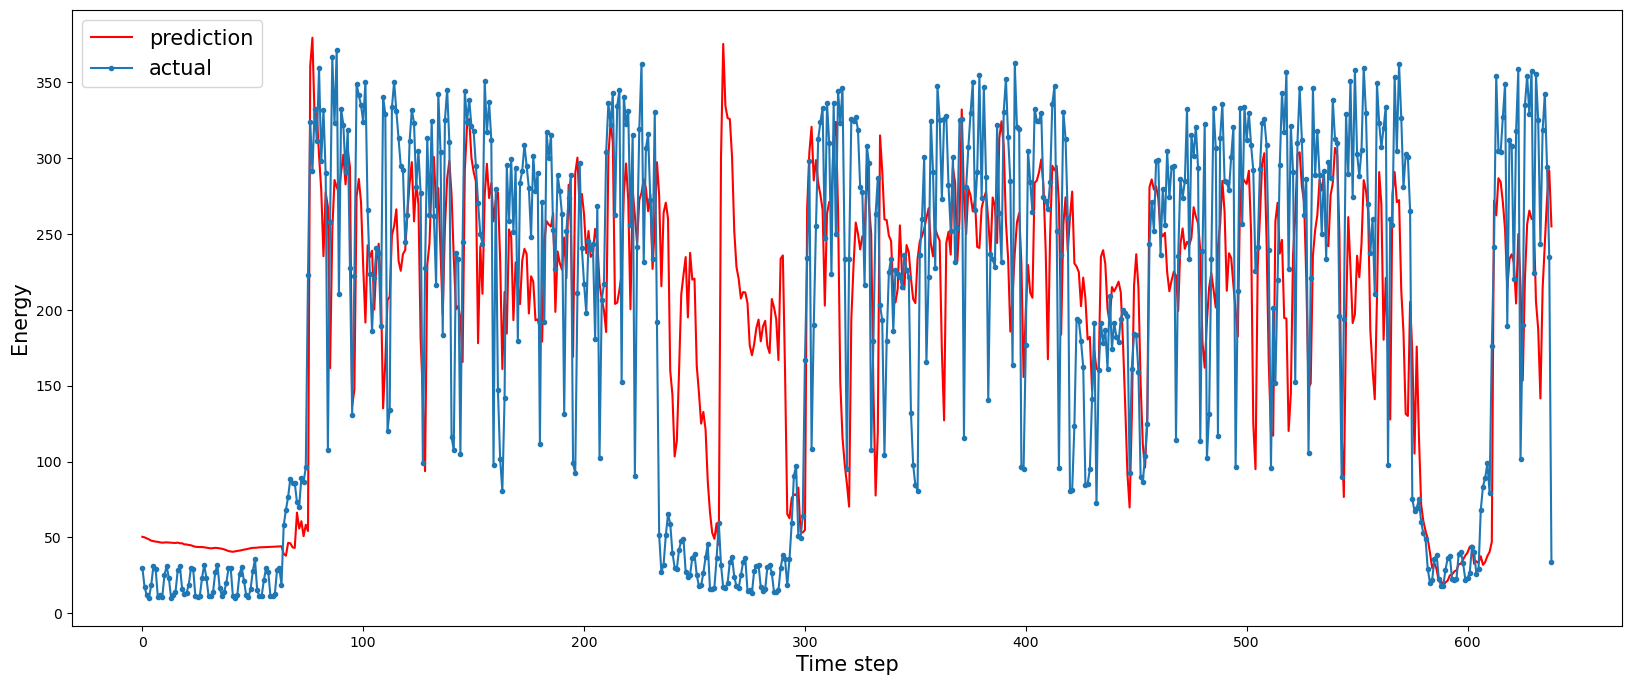

In [11]:
pyplot.figure(figsize=(20,8))
pyplot.plot(predictions, label='prediction', color="r")
pyplot.plot(original, label='actual', marker='.')
pyplot.legend()
pyplot.ylabel('Energy', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

# wandb.log({"True_vs_Predicted": pyplot})
pyplot.show()

# Trying XGBoost for the coarser intervals

In [14]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [15]:
# data = Dataset('15min')
# data = data.preprocess()
data = pd.read_csv('/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv')
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# start_time = pd.Timestamp('2022-05-31 07:00:00')
# end_time = pd.Timestamp('2022-06-01 07:30:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# start_time = pd.Timestamp('2022-05-31 08:00:00')
# end_time = pd.Timestamp('2022-06-01 09:00:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# data.to_csv('/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv')
data.drop(columns=['Unnamed: 0', 'Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [16]:
# Assuming your data is in a pandas DataFrame df with 'target' column to predict
data['lag_1'] = data['Energy'].shift(1)
data['lag_2'] = data['Energy'].shift(2)
data['lag_3'] = data['Energy'].shift(3)
data['lag_4'] = data['Energy'].shift(4)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])
categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])

scaler = StandardScaler()
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
scaled_numerical = scaler.fit_transform(data)
scaled_numerical_df = pd.DataFrame(scaled_numerical, columns = data.columns)
X_combined = pd.concat([scaled_numerical_df, categorical_data], axis=1)


y = X_combined['Energy'] 
X_combined.drop(columns = 'Energy', inplace = True)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, shuffle= False)
print("Train sizes:")
print(X_train.shape,y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)


train_data = xgb.DMatrix(X_train, label=y_train)
val_data = xgb.DMatrix(X_val, label=Y_val)
test_data = xgb.DMatrix(X_test, label=Y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (val_data, 'eval')]

# Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=10000, evals=evals, early_stopping_rounds=50, verbose_eval=100)
y_pred = model.predict(test_data)
# Calculate metrics


198.23530425829813
380.9409999996424
5.430999994277954
Train sizes:
(7425, 338) (7425,)
Validation sizes:
(655, 338) (655,)
Test sizes:
(656, 338) (656,)
[0]	train-rmse:0.98931	eval-rmse:1.01409


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [20:24:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722516643542/work/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.91847	eval-rmse:0.93136
[200]	train-rmse:0.85564	eval-rmse:0.85635
[300]	train-rmse:0.79988	eval-rmse:0.78829
[400]	train-rmse:0.75070	eval-rmse:0.72688
[500]	train-rmse:0.70747	eval-rmse:0.67263
[600]	train-rmse:0.66929	eval-rmse:0.62609
[700]	train-rmse:0.63603	eval-rmse:0.58516
[800]	train-rmse:0.60708	eval-rmse:0.54905
[900]	train-rmse:0.58174	eval-rmse:0.51584
[1000]	train-rmse:0.55934	eval-rmse:0.48627
[1100]	train-rmse:0.53957	eval-rmse:0.46037
[1200]	train-rmse:0.52206	eval-rmse:0.43850
[1300]	train-rmse:0.50667	eval-rmse:0.41791
[1400]	train-rmse:0.49315	eval-rmse:0.40140
[1500]	train-rmse:0.48112	eval-rmse:0.38569
[1600]	train-rmse:0.47081	eval-rmse:0.37271
[1700]	train-rmse:0.46177	eval-rmse:0.36076
[1800]	train-rmse:0.45391	eval-rmse:0.35093
[1900]	train-rmse:0.44717	eval-rmse:0.34272
[2000]	train-rmse:0.44109	eval-rmse:0.33570
[2100]	train-rmse:0.43542	eval-rmse:0.32976
[2200]	train-rmse:0.43026	eval-rmse:0.32474
[2300]	train-rmse:0.42570	eval-rmse:0.320

In [17]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 41))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],41))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_test.iloc[i]
    
original = scaler.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean squared error (MSE): {mean_squared_error(original, predictions)}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 84.7859641389205
Mean squared error (MSE): 14234.519564229271
Root Mean Squared Error (RMSE): 119.3085058335292
R² Score: -0.12058264579444011
Adjusted R² Score: -1.3153994731714773


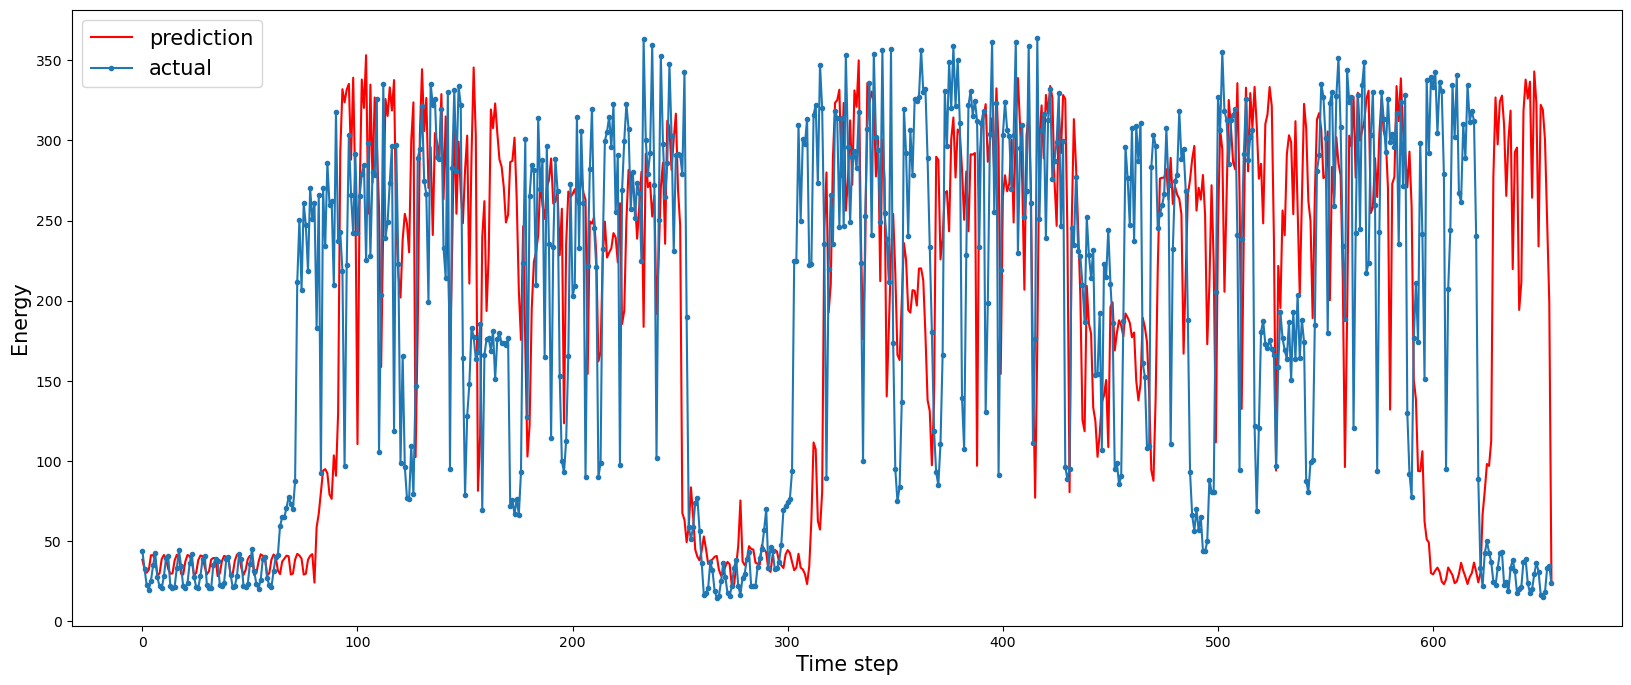

In [18]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='prediction', color="r")
plt.plot(original, label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

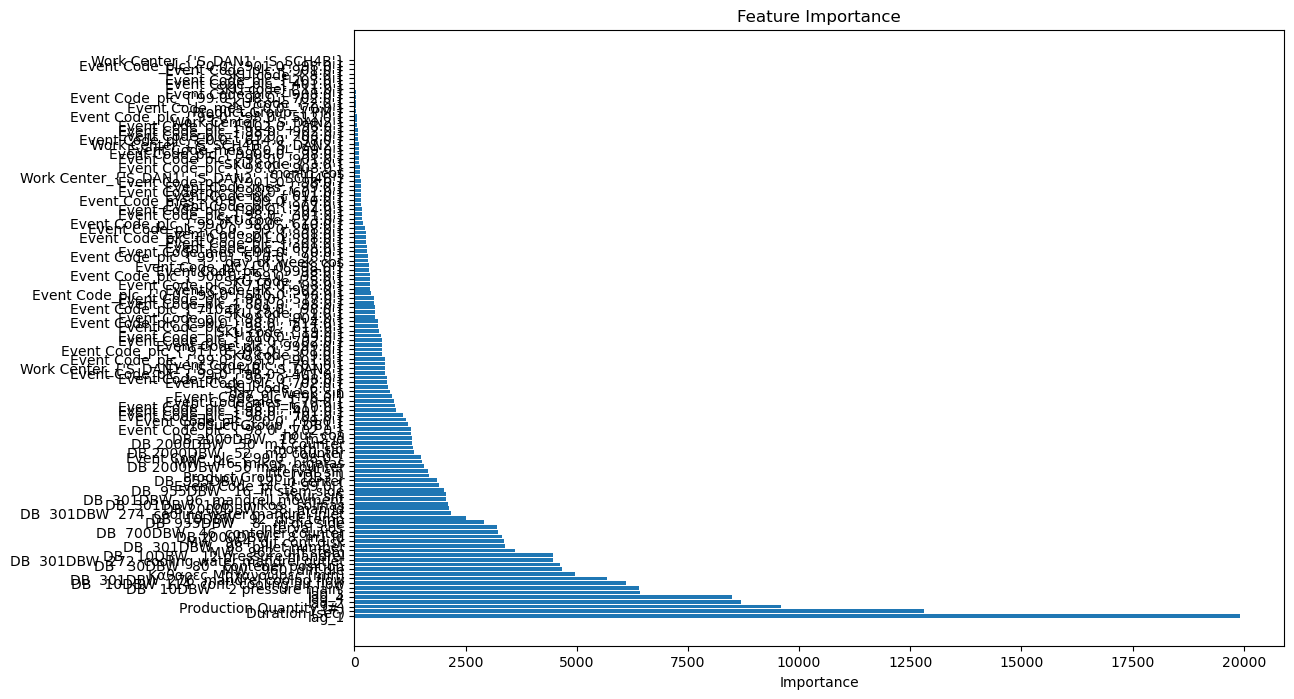

In [19]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

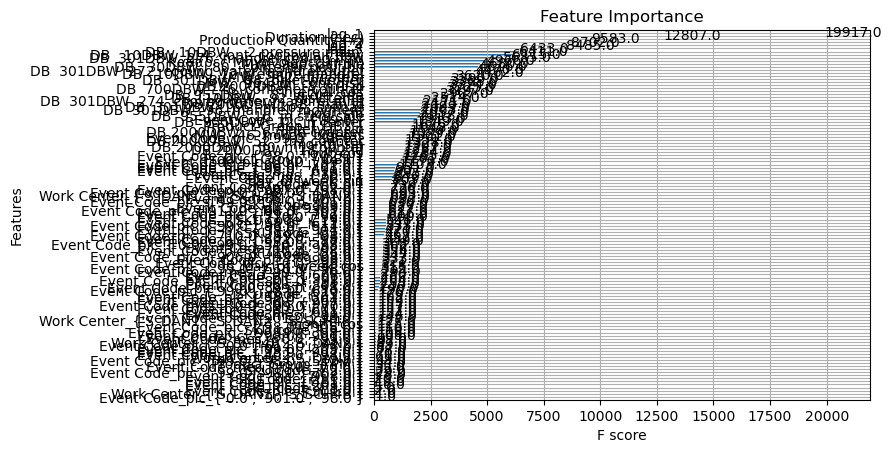

In [20]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()


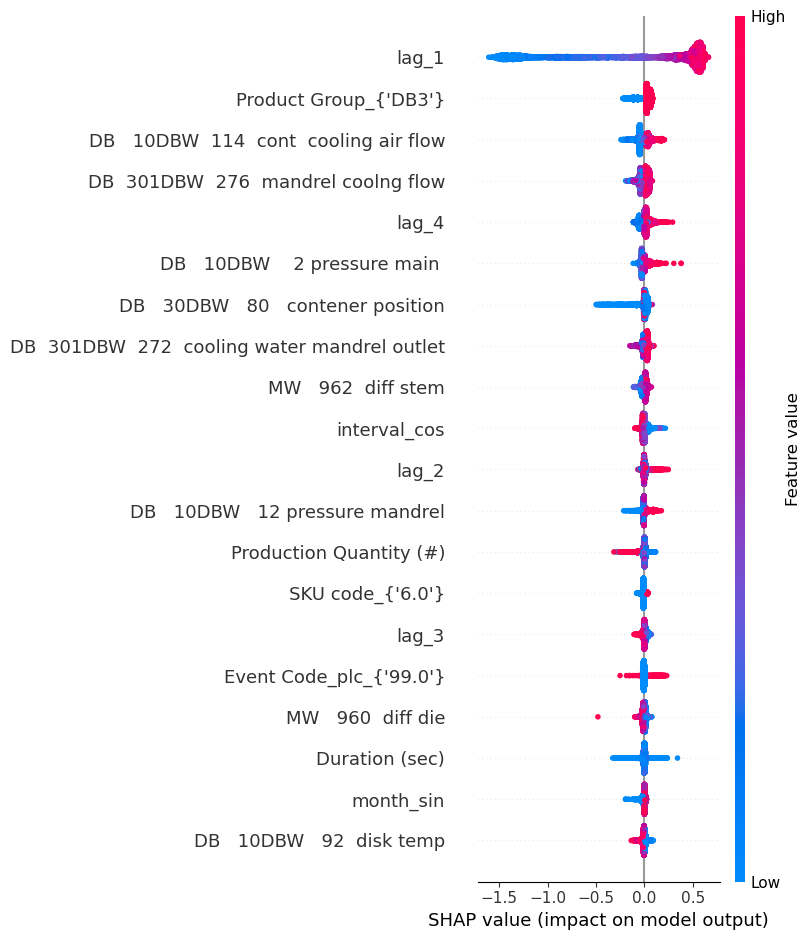

In [21]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_combined)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_combined)